In [28]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from connection_keys import connect_bq_client
import statsmodels.api as sm
import os
import warnings
import itertools
warnings.filterwarnings("ignore")

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

LOJA_LARANJA = os.environ['LOJA_LARANJA']
LOJA_VERMELHA = os.environ['LOJA_VERMELHA']

# Puxando dados do BQ
Puxando dados do BigQuery

In [2]:
client = connect_bq_client()

sql = """
    SELECT *
    FROM `db_market_product.gpu`
    ORDER BY dt_carga asc
"""

df = client.query(sql).to_dataframe()
df['data'] = df.dt_carga.dt.date
df['ds_nome_produto'] = df['ds_nome_produto'].str.upper()
df['loja'].replace([LOJA_LARANJA, LOJA_VERMELHA], ["Loja Laranja", "Loja Vermelha"],inplace=True)

# First Look
Dando uma primeira olhada nos dados salvos

In [3]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257328 entries, 0 to 1257327
Data columns (total 11 columns):
 #   Column                      Non-Null Count    Dtype              
---  ------                      --------------    -----              
 0   ds_marca                    1257328 non-null  object             
 1   ds_nome_produto             1257328 non-null  object             
 2   vl_preco_atual              1257328 non-null  float64            
 3   vl_preco_com_desconto       1257328 non-null  float64            
 4   vl_porcentagem_do_desconto  1257328 non-null  float64            
 5   qt_quantidade_estoque       531594 non-null   Int64              
 6   oferta                      1257328 non-null  object             
 7   ds_disponibilidade          1257328 non-null  object             
 8   loja                        1257328 non-null  object             
 9   dt_carga                    1257328 non-null  datetime64[ns, UTC]
 10  data                        12

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data
482847,Gigabyte,"PLACA DE VIDEO GIGABYTE RADEON RX 6800 GAMING OC 16GB GDDR6 2‎56-BIT, GV-R68GAMING OC-16GD",8174.45,8174.45,12.0,<NA>,None,OUT_OF_STOCK,Loja Vermelha,2022-12-24 10:01:37.587326+00:00,2022-12-24
1115419,Galax,"PLACA DE VÍDEO GALAX NVIDIA GEFORCE GTX 1660 1-CLICK OC, 6GB, GDDR5 - 60SRH7DSY91C",1999.99,1699.99,15.0,9,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 1894.11, 'vl_oferta_preco_com_desconto': 1609.99, 'vl_oferta_porcentagem_do_desconto': 5}]",True,Loja Laranja,2023-04-14 10:01:48.862419+00:00,2023-04-14
252446,PNY,"PLACA DE VIDEO PNY GEFORCE GTX 1650 4GB GDDR6 128-BIT, GMX1650N3J4FP2AKTP",2704.53,2704.53,12.0,<NA>,None,OUT_OF_STOCK,Loja Vermelha,2022-11-12 10:01:48.922531+00:00,2022-11-12
637161,Gigabyte,"PLACA DE VIDEO GIGABYTE GEFORCE RTX 2080 8GB GDDR6 OC WHITE 256-BIT, GV-N2080GAMINGOC WHITE-8GC",4657.90,4657.90,12.0,<NA>,None,OUT_OF_STOCK,Loja Vermelha,2023-01-20 22:02:12.623748+00:00,2023-01-20
617331,Zotac,"PLACA DE VIDEO ZOTAC GEFORCE RTX 3090 AMP EXTREME HOLO, 24GB, GDDR6X, 384-BIT, ZT-A30900B-10P",11374.35,11374.35,12.0,<NA>,None,OUT_OF_STOCK,Loja Vermelha,2023-01-17 10:01:33.457717+00:00,2023-01-17


In [4]:
df.isnull().sum()

ds_marca                           0
ds_nome_produto                    0
vl_preco_atual                     0
vl_preco_com_desconto              0
vl_porcentagem_do_desconto         0
qt_quantidade_estoque         725734
oferta                             0
ds_disponibilidade                 0
loja                               0
dt_carga                           0
data                               0
dtype: int64

In [5]:
columns = ["ds_marca", "ds_disponibilidade", "loja", "oferta"]

for column in columns:
  print(df[column].unique())

['Nvidia' 'Gigabyte' 'Colorful' 'Asus' 'PALIT' 'Afox' 'Gainward' 'Pny'
 'PCYES' 'GOLDENTEC' 'Axle' 'MSI' 'Liketec' 'Galax' 'Knup' 'DT3sports'
 'GOLINE' 'Lian Li' 'Hp' 'imperiums' 'Duex' 'Bluecase' 'PCWINMAX'
 'Riser Card' '5TECHPC' 'Powercolor' 'Zotac' 'DEX' 'DarkFlash' 'Outros'
 'Evga' 'OFICINA DOS BITS' 'Cooler Master' 'Brazil PC' 'Thermaltake'
 'Barrow' 'Arktek' 'XFX' 'Biostar' 'Amd' 'Ctech' 'Deepcool' 'Valianty'
 'Grizzly' 'Power Color' 'ASRock' 'PNY' 'AMD' 'AFOX' 'ZOGIS' 'EVGA'
 'PCYES!' 'Sapphire' 'Mancer' 'PowerColor' 'AsRock' 'Enzatec' 'Akasa'
 'Rise Mode' 'Gibayte' 'PNY Technologies' 'Aorus' 'Zogis' 'Point'
 'Genérica' 'Inno 3d' 'NEOLOGIC' 'Superframe' 'TGT' 'Chroma Tech'
 'Adamantiun' 'Storm-z' 'Goldentec' 'Evolut' 'INNO3D' 'Intel' 'BRX'
 'Power' 'ASUS']
['False' 'True' 'OUT_OF_STOCK' 'IN_STOCK']
['Loja Laranja' 'Loja Vermelha']
['None'
 "[{'ds_oferta_nome': 'Setembro Tech', 'vl_oferta_preco_atual': 359.1, 'vl_oferta_preco_com_desconto': 359.1, 'vl_oferta_porcentagem_do_desco

# Explorando os dados

Como o processo roda duas vezes ao dia, vale a verificação se houve algum dia em que foi rodado mais vezes no mesmo dia.

In [6]:
df_verification_days = df.groupby(['data', 'loja'])['dt_carga'].nunique().reset_index(name='counts')
df_verification_days.query("counts > 2")

,data,loja,counts
26,2022-10-12,Loja Laranja,4
27,2022-10-12,Loja Vermelha,4
28,2022-10-13,Loja Laranja,3
29,2022-10-13,Loja Vermelha,3
30,2022-10-14,Loja Laranja,3
31,2022-10-14,Loja Vermelha,3
32,2022-10-15,Loja Laranja,3
33,2022-10-15,Loja Vermelha,3
34,2022-10-16,Loja Laranja,3
35,2022-10-16,Loja Vermelha,3


Como pode ser visto, na coluna "ds_disponibilidade" existem diferentes formas de dizer se um item está em estoque atualmente ou não, a forma como isso é apresentado depende da loja, para que em ambas as lojas a informação fique equalizada, será alterado os tipos "OUT_OF_STOCK" e "IN_STOCK" para true e false.

In [7]:
# Alterando o campo "ds_disponibilidade" para booleano
df['ds_disponibilidade'].replace(["OUT_OF_STOCK", "IN_STOCK"], [False, True],inplace=True)
df['ds_disponibilidade'] = df['ds_disponibilidade'].astype(bool)

Para ficar mais fácil de filtrar as placas de vídeo em si de outros produtos que estão presentes, a partir de um padrão de informação, será criado um campo novo com a descrição resumida do nome da placa.
<p><b>EVOLUÇÃO: PEGAR O NOME DA PLACA UTILIZANDO TÉNICAS DE NLP</b></p>

In [8]:
def get_resume_product_name(name):
  """
    Description: Com base no padrão de nomenclatura das placas de vídeo, cria um novo
    campo com o nome abreviado do modelo.
  """
  pattern = "(RTX|GTX|GT|RX|WX|QUADRO|R7|R5|R9|HD)(.?.?)((\w*)\d+)( ?(TI|XT|X|SUPER))?"
  resume_name = re.search(pattern, name)
  if resume_name is None:
      return None
  else:
      return resume_name.group().strip()

df['ds_nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['ds_nome_produto']), axis=1)

Efetua a separação e filtragem do dataframe atraves das datas do dia, pegando apenas a última leitura do dia para a análise, mas salva as primeiras datas para possíveis comprações de datas dentro do mesmo dia.

In [9]:
maxDf = df.groupby(['data'])['dt_carga'].max()
minDf = df.groupby(['data'])['dt_carga'].min()
maxDates = maxDf.tolist()
minDates = minDf.tolist()
df_max = df.loc[df['dt_carga'].isin(maxDates)]
df_min = df.loc[df['dt_carga'].isin(minDates)]

Filtra o dataset para ter apenas os produtos com nomes válidos de placa

In [10]:
df_gpu = df_max.loc[~df_max.ds_nome_produto_resumido.isnull()]
print(f"""Tamanho do dataframe com todos os produtos: {df_max.shape[0]} \nTamanho do dataframe apenas com produtos válidos: {df_gpu.shape[0]}""")


Tamanho do dataframe com todos os produtos: 616078 
Tamanho do dataframe apenas com produtos válidos: 598385


Análise de variação de preço ao longo do tempo para o valor base e o valor com desconto

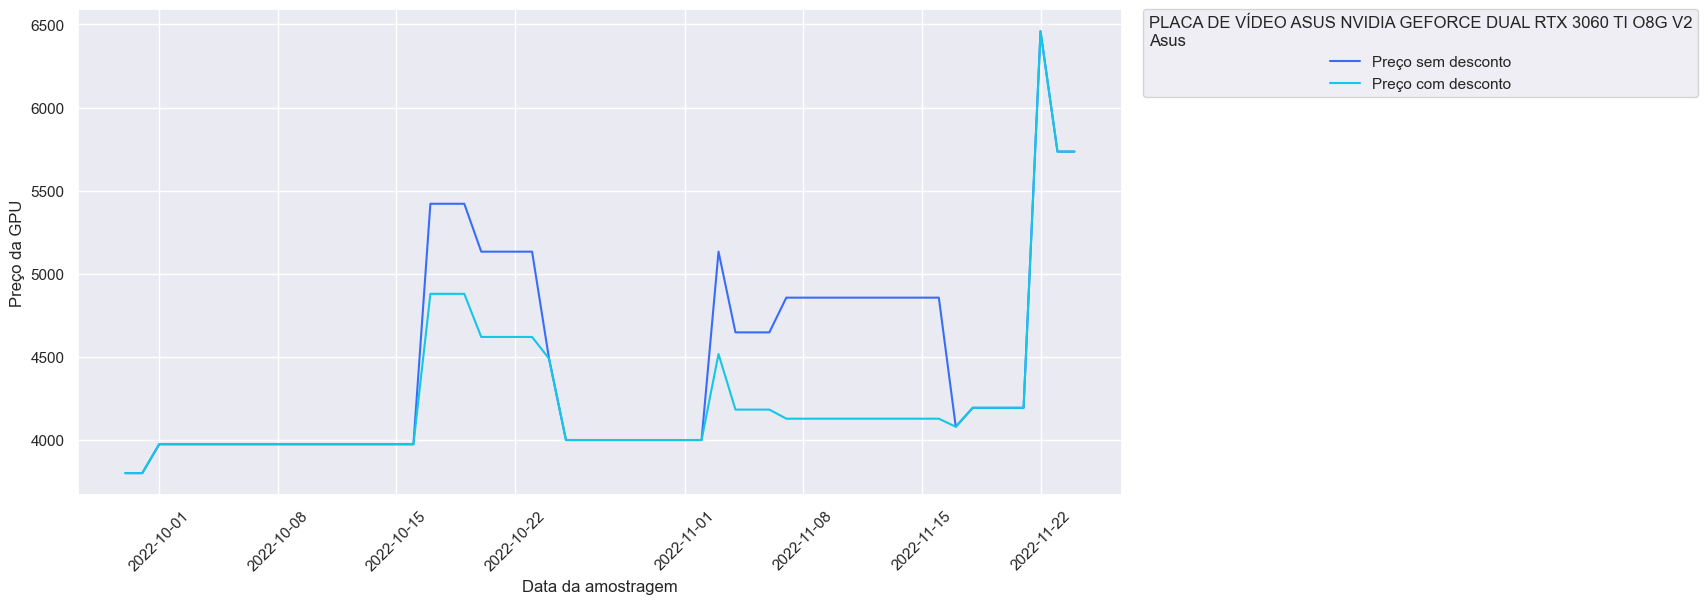

In [11]:
# query_gpu.
index = 8
product_name = "RTX 3060 TI"
store = "Loja Laranja"

query_gpu_line = df_gpu.query(f""" ds_nome_produto_resumido == "{product_name}" and loja == "{store}" """).iloc[index]
query_gpu_line.drop_duplicates(keep="first")

gpu_name = query_gpu_line.ds_nome_produto
brand_name = query_gpu_line.ds_marca

query_gpu = df_gpu.query(f""" ds_nome_produto == "{gpu_name}" and loja == "{store}" """)

sns.set(rc={'figure.figsize':(12,6)})
sns.set_palette('rainbow')
plt.xticks(rotation = 45)
sns.lineplot(x="data", y="vl_preco_atual", data=query_gpu, label='Preço sem desconto')
sns.lineplot(x="data", y="vl_preco_com_desconto", data=query_gpu, label='Preço com desconto')
plt.ylabel("Preço da GPU")
plt.xlabel("Data da amostragem")
plt.legend(bbox_to_anchor=(1.02, 1),borderaxespad=0, title=f"{re.match('[^,]+', gpu_name).group(0)}\n{brand_name}");

In [12]:
df_gpu.query(""" ds_nome_produto_resumido == "RTX 2060 SUPER" and loja == "Loja Laranja" """).iloc[index]


ds_marca                                                                                        Colorful
ds_nome_produto               PLACA DE VIDEO COLORFUL GEFORCE RTX 2060 SUPER NB, V2-V 8GB, GDDR6, 256BIT
vl_preco_atual                                                                                    2379.0
vl_preco_com_desconto                                                                             2379.0
vl_porcentagem_do_desconto                                                                           0.0
qt_quantidade_estoque                                                                                104
oferta                                                                                              None
ds_disponibilidade                                                                                  True
loja                                                                                        Loja Laranja
dt_carga                                               

In [36]:

import json
df_gpu_laranja = df_gpu.loc[df_gpu['loja'] == 'Loja Laranja']
# df_gpu.sample(3)

df_gpu_laranja['oferta'] = df_gpu_laranja['oferta'].str.replace("'", '"')

# Supondo que 'df' seja seu DataFrame e substituindo 'None' com np.nan
df_gpu_laranja['oferta'].replace('None', np.nan, inplace=True)

# Função para extrair valores do JSON
def parse_json(data):
    if not pd.isna(data):
        # print(data.oferta)
        j = json.loads(data)
        data = pd.json_normalize(j)
    return data

# Aplicando a função de parse e expandindo a coluna 'oferta'
df_parsed = df_gpu_laranja["oferta"].apply(parse_json)

# Renomeando as colunas parseadas
# df_parsed.columns = [f'promo_{col}' for col in df_parsed.columns]

# # Concatenando o DataFrame original com as colunas parseadas
# df_gpu_laranja = pd.concat([df_gpu_laranja, df_parsed], axis=1)

In [54]:
import ast

# Supondo que 'df' seja seu DataFrame e substituindo 'None' com np.nan
df_gpu['oferta'].replace('None', np.nan, inplace=True)

# Função para extrair valores do JSON
def parse_json(data):
    try:
        j = ast.literal_eval(data)
        if j:
            return j[0]
        else:
            return {}
    except:
        return {}

# Aplicando a função de parse e criando um novo DataFrame com as colunas parseadas
df_oferta = df_gpu['oferta'].apply(parse_json).apply(pd.Series)

# Renomeando as colunas parseadas
df_oferta.columns = [f'promo_{col}' for col in df_oferta.columns]

# Concatenando o DataFrame original com as colunas parseadas
df = pd.concat([df_gpu, df_oferta], axis=1)

In [78]:
df.sample(10)

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data,ds_nome_produto_resumido,promo_ds_oferta_nome,promo_vl_oferta_preco_atual,promo_vl_oferta_preco_com_desconto,promo_vl_oferta_porcentagem_do_desconto
357566,Gigabyte,"PLACA DE VÍDEO GIGABYTE GEFORCE GTX 1650 D6 OC 4GB, GDDR6, 128BITS - GVN1656OC4GD REV 2.0",2260.61,2034.55,10.0,0,NaN,True,Loja Laranja,2022-12-01 22:01:39.701577+00:00,2022-12-01,GTX 1650,NaN,NaN,NaN,NaN
229545,Asus,"PLACA DE VIDEO ASUS GEFORCE GTX 950 OC 2GB GDDR5 ROG STRIX 128-BIT, STRIX-GTX950-DC2OC-2GD5-GAMING",771.60,771.60,12.0,<NA>,NaN,False,Loja Vermelha,2022-11-07 22:01:52.067517+00:00,2022-11-07,GTX 950,NaN,NaN,NaN,NaN
1084998,Sapphire,"PLACA DE VIDEO SAPPHIRE RADEON RX 460 4GB GDDR5 NITRO OC 128-BIT, 11257-02-20G",646.61,646.61,12.0,<NA>,NaN,False,Loja Vermelha,2023-04-08 22:01:29.306394+00:00,2023-04-08,RX 460,NaN,NaN,NaN,NaN
708907,Asus,"PLACA DE VIDEO ASUS GEFORCE RTX 2060 DUAL OC EDITION 6GB GDDR6 192-BIT, DUAL-RTX2060-O6G-EVO",2549.02,2176.46,12.0,<NA>,"[{'ds_oferta_nome': 'Ferias', 'vl_oferta_preco_atual': 2549.02, 'vl_oferta_preco_com_desconto': 2176.46, 'vl_oferta_porcentagem_do_desconto': 14.62}]",True,Loja Vermelha,2023-02-02 22:01:34.630842+00:00,2023-02-02,RTX 2060,Ferias,2549.02,2176.46,14.62
1089845,Zotac,"PLACA DE VÍDEO ZOTAC NVIDIA GEFORCE RTX 3070 TWIN EDGE OC, 8GB GDDR6 - ZT-A30700H-10P",10857.90,10857.90,0.0,0,NaN,True,Loja Laranja,2023-04-09 22:01:49.670300+00:00,2023-04-09,RTX 3070,NaN,NaN,NaN,NaN
653926,Gigabyte,"PLACA DE VIDEO GIGABYTE GEFORCE GT 210 1GB DDR3 LOW PROFILE 64-BIT GDDR3, GV-N210D3-1GI",159.90,159.90,12.0,<NA>,NaN,False,Loja Vermelha,2023-01-23 22:01:46.827208+00:00,2023-01-23,GT 210,NaN,NaN,NaN,NaN
708525,ASRock,"PLACA DE VÍDEO RX 550 ASROCK AMD RADEON PHANTOM GAMING, 2GB GDDR5 - 90-GA0500-00UANF",1089.66,926.21,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 1056.97, 'vl_oferta_preco_com_desconto': 898.42, 'vl_oferta_porcentagem_do_desconto': 3}]",True,Loja Laranja,2023-02-02 22:01:34.630842+00:00,2023-02-02,RX 550,Prime,1056.97,898.42,3.00
293611,Galax,"PLACA DE VIDEO GALAX GEFORCE RTX 2080 SUPER EX 8GB GDDR6 1-CLICK OC 256-BIT, 28ISL6MDU9EX",4449.00,4449.00,12.0,<NA>,NaN,False,Loja Vermelha,2022-11-19 22:01:54.279758+00:00,2022-11-19,RTX 2080 SUPER,NaN,NaN,NaN,NaN
670579,Gigabyte,"PLACA DE VIDEO GIGABYTE GEFORCE RTX 2070 8GB GDDR6 OC WHITE 256-BIT, GV-N2070GAMINGOC WHITE-8GC",3351.10,3351.10,12.0,<NA>,NaN,False,Loja Vermelha,2023-01-26 22:01:37.436107+00:00,2023-01-26,RTX 2070,NaN,NaN,NaN,NaN
229525,Gigabyte,"PLACA DE VIDEO GIGABYTE GEFORCE GTX 1060 3GB GDDR5 G1 GAMING WINDFORCE 192-BIT, GV-N1060WF2OC-3GD",1278.39,1278.39,12.0,<NA>,NaN,False,Loja Vermelha,2022-11-07 22:01:52.067517+00:00,2022-11-07,GTX 1060,NaN,NaN,NaN,NaN


In [15]:
teste = df_gpu_laranja.loc[1257321]["oferta"]
teste

j = json.loads('[{"ds_oferta_nome": "Prime", "vl_oferta_preco_atual": 1341.16, "vl_oferta_preco_com_desconto": 1139.99, "vl_oferta_porcentagem_do_desconto": 5}]')

j
# df_gpu_laranja['oferta'].apply(parse_json)

[{'ds_oferta_nome': 'Prime',
  'vl_oferta_preco_atual': 1341.16,
  'vl_oferta_preco_com_desconto': 1139.99,
  'vl_oferta_porcentagem_do_desconto': 5}]

Produtos que mais apresentaram variação do preço base ao longo do tempo

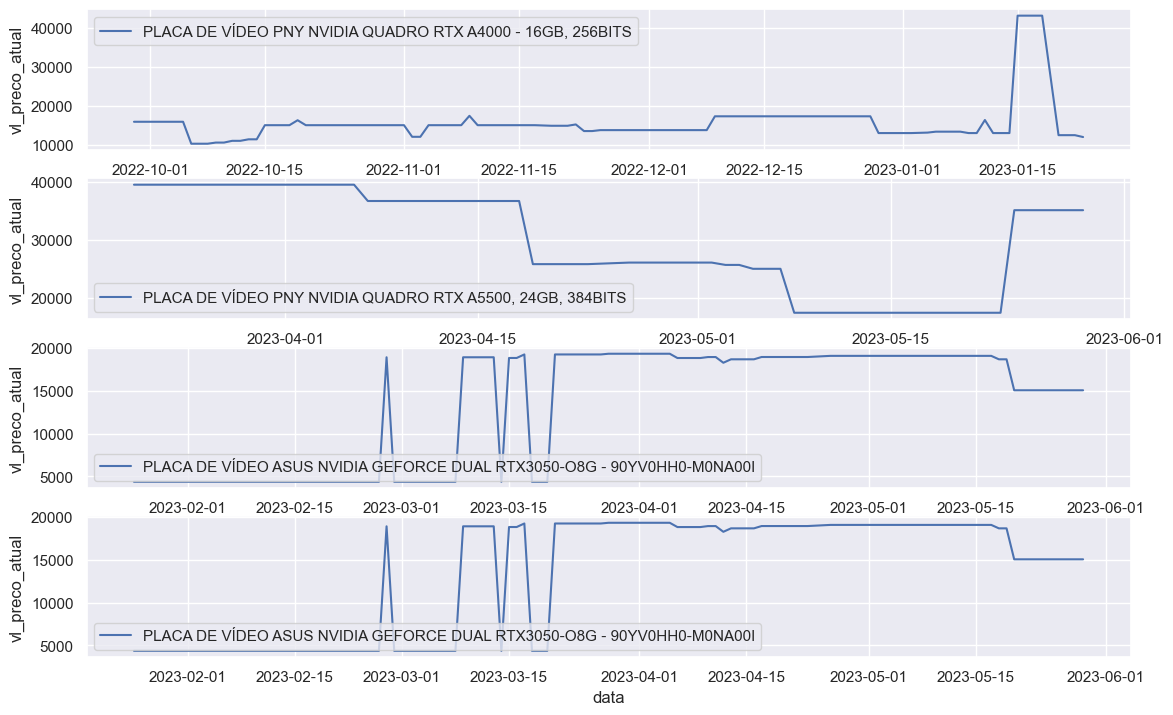

In [16]:
query_dif = df_gpu.sort_values('data').set_index('data').groupby(['ds_nome_produto', "loja"]).apply(lambda x: x['vl_preco_atual'].diff()).reset_index().nlargest(4, "vl_preco_atual")
fig, axes = plt.subplots(4)
sns.set(rc={'figure.figsize':(12,8)})

graph_1 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[0].ds_nome_produto}" and loja == "{query_dif.iloc[0].loja}" """)
graph_2 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[1].ds_nome_produto}" and loja == "{query_dif.iloc[1].loja}" """)
graph_3 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[2].ds_nome_produto}" and loja == "{query_dif.iloc[2].loja}" """)
graph_4 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[3].ds_nome_produto}" and loja == "{query_dif.iloc[3].loja}" """)

sns.lineplot(x="data", y="vl_preco_atual", data=graph_1, label=f"{query_dif.iloc[0].ds_nome_produto}", ax=axes[0])
sns.lineplot(x="data", y="vl_preco_atual", data=graph_2, label=f"{query_dif.iloc[1].ds_nome_produto}", ax=axes[1])
sns.lineplot(x="data", y="vl_preco_atual", data=graph_3, label=f"{query_dif.iloc[2].ds_nome_produto}", ax=axes[2])
sns.lineplot(x="data", y="vl_preco_atual", data=graph_4, label=f"{query_dif.iloc[3].ds_nome_produto}", ax=axes[3]);


Qual marca possui produtos mais caros?
<p>É importante levar em consideração que muitas marcas podem não possuir os mesmos tipos de produtos, como por exemplo alguma marca não vender modelos de séries mais caras. Esse fator pode influenciar no valor total somado.</p>
<p>Por isso, o mais indicado seria uma comparação levando em consideração produtos do mesmo patamar, utilizando o campo ds_nome_produto_resumido para agrupar essas classes</p>

In [41]:
query_loja_marca = df_gpu.drop_duplicates(keep="first")
query_loja_marca = query_loja_marca.groupby(["loja", 'ds_marca'])["vl_preco_atual"].sum().to_frame()
query_loja_marca = query_loja_marca.reset_index()

fig = px.treemap(query_loja_marca, path=['loja', 'ds_marca'],
                 values='vl_preco_atual')

fig.show()

In [62]:
query_loja_marca = df_gpu.drop_duplicates(keep="first")
query_loja_marca = query_loja_marca.groupby(["loja", "ds_nome_produto_resumido", "ds_marca"])["vl_preco_atual"].apply(lambda grp: grp.nlargest(5).sum()).to_frame()
query_loja_marca = query_loja_marca.reset_index()
query_loja_marca.groupby(["loja", "ds_nome_produto_resumido"]).apply(lambda grp: grp.nlargest(5, "vl_preco_atual")).reset_index(drop=True)
# fig = px.treemap(query_loja_marca, path=["loja", "ds_nome_produto_resumido", "ds_marca"],
#                  values="vl_preco_atual")

# fig.show()

,loja,ds_nome_produto_resumido,ds_marca,vl_preco_atual
0,Loja Laranja,GT 1030,PCYES,6999.50
1,Loja Laranja,GT 1030,Galax,6395.00
2,Loja Laranja,GT 1030,Asus,5995.00
3,Loja Laranja,GT 1030,Evga,5293.55
4,Loja Laranja,GT 1030,Gigabyte,4708.90
...,...,...,...,...
839,Loja Vermelha,RX 7900 XT,AsRock,52352.90
840,Loja Vermelha,RX-VEGMLBFX6,XFX,13331.65
841,Loja Vermelha,RX-VEGMTBFX6,XFX,16430.70
842,Loja Vermelha,RX-VEGMTSFX6,XFX,16430.70


In [42]:
df_gpu.query(""" ds_marca == "Bluecase" """)

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data,ds_nome_produto_resumido
2693,Bluecase,"PLACA DE VÍDEO GTX 750TI 2GB, DDR5, 128BITS, BLUECASE",1120.00,1120.00,0.0,0,None,True,Loja Laranja,2022-09-29 22:01:30.406181+00:00,2022-09-29,GTX 750TI
2697,Bluecase,"PLACA DE VÍDEO GTX 750, 2GB, DDR5, 128BITS - BLUECASE",945.00,945.00,0.0,0,None,True,Loja Laranja,2022-09-29 22:01:30.406181+00:00,2022-09-29,GTX 750
2756,Bluecase,"GEFORCE GT 730 2GB, GDDR3, 128 BITS, BLUECASE, BP-GT730-2GD3D1",667.63,667.63,0.0,0,None,True,Loja Laranja,2022-09-29 22:01:30.406181+00:00,2022-09-29,GT 730
3172,Bluecase,"PLACA DE VÍDEO NVIDIA GEFORCE GTX 1050 2GB, GDDR5 - BP-GTX1050-2GB5D1 BLUECASE",2015.99,1814.39,10.0,0,None,True,Loja Laranja,2022-09-29 22:01:30.406181+00:00,2022-09-29,GTX 1050
8019,Bluecase,"PLACA DE VÍDEO GTX 750TI 2GB, DDR5, 128BITS, BLUECASE",1120.00,1120.00,0.0,0,None,True,Loja Laranja,2022-09-30 22:01:22.660381+00:00,2022-09-30,GTX 750TI
...,...,...,...,...,...,...,...,...,...,...,...,...
583464,Bluecase,PLACA DE VIDEO BLUECASE GEFORCE GT 610 1GB DDR3 64BITS HDMI,239.90,239.90,0.0,0,None,True,Loja Laranja,2023-01-11 10:02:15.747552+00:00,2023-01-11,GT 610
583465,Bluecase,"GEFORCE GT 730 2GB, GDDR3, 128 BITS, BLUECASE, BP-GT730-2GD3D1",667.63,667.63,0.0,0,None,True,Loja Laranja,2023-01-11 10:02:15.747552+00:00,2023-01-11,GT 730
583466,Bluecase,"PLACA DE VÍDEO GTX 750, 2GB, DDR5, 128BITS - BLUECASE",945.00,945.00,0.0,0,None,True,Loja Laranja,2023-01-11 10:02:15.747552+00:00,2023-01-11,GTX 750
583467,Bluecase,"PLACA DE VÍDEO GTX 750TI 2GB, DDR5, 128BITS, BLUECASE",1120.00,1120.00,0.0,0,None,True,Loja Laranja,2023-01-11 10:02:15.747552+00:00,2023-01-11,GTX 750TI


503
{'_value': 'html', 'html': [{'_attributes': {'lang': 'pt-br', 'dir': 'ltr'}, 'head': [{'title': [{'_value': 'Under attack mode | TerabyteShop'}], 'meta': [{'_attributes': {'charset': 'UTF-8'}}, {'_attributes': {'name': 'viewport', 'content': 'width=device-width,minimum-scale=1,initial-scale=1'}}, {'_attributes': {'http-equiv': 'refresh', 'content': '35'}}], 'link': [{'_attributes': {'rel': ['shortcut', 'icon'], 'href': 'https://landing.terabyteshop.com.br/templatescdn/favicon.png', 'type': 'image/x-icon'}}, {'_attributes': {'href': 'https://fonts.googleapis.com/css2?family=Open+Sans:wght@400;800&display=optional', 'rel': ['preload']}}], 'style': [{'_value': 'body{font-family:Open Sans,sans-serif;font-weight:400;padding:0;margin:0;background:#191919}.topo{background-color:#2d2d2d;border-bottom:2px solid #ff5800;height:80px;display:flex}.img-responsive{max-width:100%;height:auto;display:block;margin:auto}.cont_erro{height:80vh;display:flex;justify-content:center;align-items:center;fl
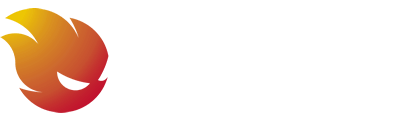

In [4]:
import html_to_json
import requests

username = 'vgtgayan'
base_url = 'https://www.terabyteshop.com.br/hardware/placas-de-video'
url = base_url

r = requests.post(url)
print(r.status_code)

html_string = r.text
output_json = html_to_json.convert(html_string)
print(output_json)

# df = pd.read_html("https://www.terabyteshop.com.br/hardware/placas-de-video")
# df

In [140]:
df.iloc[df.index == 187159]['ds_nome_produto'].tolist() # ds_nome_produto_resumido ds_nome_produto

['PLACA DE VÍDEO ASUS KO NVIDIA GEFORCE RTX3070 V2 GAMING, RGB, 14 GBPS, 8GB GDDR6, DLSS, LHR, RAY TRACING - KO-RTX3070-08G-V2-GAMING']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384100 entries, 0 to 384099
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   ds_marca                    384100 non-null  object             
 1   ds_nome_produto             384100 non-null  object             
 2   vl_preco_atual              384100 non-null  float64            
 3   vl_preco_com_desconto       384100 non-null  float64            
 4   vl_porcentagem_do_desconto  384100 non-null  float64            
 5   qt_quantidade_estoque       142715 non-null  Int64              
 6   oferta                      384100 non-null  object             
 7   ds_disponibilidade          384100 non-null  object             
 8   loja                        384100 non-null  object             
 9   dt_carga                    384100 non-null  datetime64[ns, UTC]
 10  data                        384100 non-null 

,data,loja,counts
26,2022-10-12,Kabum,4
27,2022-10-12,Pichau,4
28,2022-10-13,Kabum,3
29,2022-10-13,Pichau,3
30,2022-10-14,Kabum,3
31,2022-10-14,Pichau,3
32,2022-10-15,Kabum,3
33,2022-10-15,Pichau,3
34,2022-10-16,Kabum,3
35,2022-10-16,Pichau,3


In [14]:
# df_datas_loja = df.groupby(['data', 'loja'])['dt_carga'].nunique()
# df_datas_loja


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
# nltk.download('popular') # Rodar apenas uma vez para fazer a instalação


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.

True

In [10]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent
ex = "PLACA DE VÍDEO ASUS NVIDIA GEFORCE GTX 1050 TI OC CERBERUS, 4GB GDDR5 - CERBERUS-GTX1050TI-O4G"
sent = preprocess(ex)
sent
pattern = 'NP: {<NNP>*<CD>*<NNP>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
print(cs)

(S
  (NP
    PLACA/NNP
    DE/NNP
    VÍDEO/NNP
    ASUS/NNP
    NVIDIA/NNP
    GEFORCE/NNP
    GTX/NNP
    1050/CD
    TI/NNP)
  (NP OC/NNP CERBERUS/NNP)
  ,/,
  (NP 4GB/CD GDDR5/NNP)
  -/:
  CERBERUS-GTX1050TI-O4G/NN)


In [13]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)
ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(ex)))
print(ne_tree)

[('PLACA', 'NNP', 'B-NP'),
 ('DE', 'NNP', 'I-NP'),
 ('VÍDEO', 'NNP', 'I-NP'),
 ('ASUS', 'NNP', 'I-NP'),
 ('NVIDIA', 'NNP', 'I-NP'),
 ('GEFORCE', 'NNP', 'I-NP'),
 ('GTX', 'NNP', 'I-NP'),
 ('1050', 'CD', 'I-NP'),
 ('TI', 'NNP', 'I-NP'),
 ('OC', 'NNP', 'B-NP'),
 ('CERBERUS', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('4GB', 'CD', 'B-NP'),
 ('GDDR5', 'NNP', 'I-NP'),
 ('-', ':', 'O'),
 ('CERBERUS-GTX1050TI-O4G', 'NN', 'O')]
(S
  (ORGANIZATION PLACA/NNP)
  (PERSON DE/NNP)
  VÍDEO/NNP
  ASUS/NNP
  NVIDIA/NNP
  GEFORCE/NNP
  GTX/NNP
  1050/CD
  TI/NNP
  OC/NNP
  CERBERUS/NNP
  ,/,
  4GB/CD
  (ORGANIZATION GDDR5/NNP)
  -/:
  CERBERUS-GTX1050TI-O4G/NN)


In [5]:
def get_resume_product_name(name):
    # string = df['nome_produto'][df['id'] == 259].item()
    pattern = "(RTX|GTX|GT|RX|WX|Quadro|R7|R5|R9|HD)\s(\d+)"
    resume_name = re.search(pattern, name)
    if resume_name is None:
        return ''
    else:
        return resume_name.group()

df['ds_nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['ds_nome_produto']), axis=1)

In [17]:
df.sample(10)

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data
45913,XFX,"PLACA DE VIDEO XFX RADEON R7 360 2GB GDDR5 128-BIT, R7-360P-2DF5",576.15,576.15,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-07 22:01:28.788032+00:00,2022-10-07
389705,Galax,"PLACA DE VÍDEO, NVIDIA GALAX GEFORCE, GTX 1630 4GB, DDR6, 64 BITS",1021.59,970.51,5.0,26,None,True,Kabum,2022-12-07 22:01:41.943312+00:00,2022-12-07
297416,Evga,PLACA DE VIDEO RTX 3060 TI 8GB GDDR6 256BITS DUAL FAN 08G-P5-3663-KL EVGA,5395.90,4586.51,15.0,0,None,False,Kabum,2022-11-20 22:02:00.222487+00:00,2022-11-20
254406,Pny,"PLACA DE VIDEO PNY NVIDIA QUADRO T1000, 4GB, GDDR6, 128 BITS, LOW PROFILE - VCNT1000-PORPB",3437.59,3265.71,5.0,0,None,False,Kabum,2022-11-12 22:01:49.274075+00:00,2022-11-12
440210,MSI,PLACA DE VÍDEO MSI GEFORCE GTX 1060 ARMOR 6G OCV1 GDDR5 192BIT,1541.00,1541.00,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-12-16 22:01:23.029774+00:00,2022-12-16
534484,Asus,"PLACA DE VÍDEO GTX 1660 ASUS PHOENIX NVIDIA GEFORCE 6GB, GDDR5 - PH-GTX1660-O6G",2941.16,2499.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 2852.93, 'vl_oferta_preco_com_desconto': 2424.99, 'vl_oferta_porcentagem_do_desconto': 2}]",False,Kabum,2023-01-02 22:01:51.287766+00:00,2023-01-02
212028,AMD,"PLACA DE VIDEO AFOX RADEON RX 550 4GB 128-BIT, AFRX550-4096D5H3",737.52,737.52,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-11-04 22:01:26.935871+00:00,2022-11-04
444865,Knup,"PLACA DE VÍDEO PARA PC DESKTOP, 2GB, DDR3, 64BIT, VGA HDMI, NVIDIA GEFORCE KNUP - KP-GT730/BB",549.80,549.80,0.0,1000,None,True,Kabum,2022-12-17 22:01:36.828901+00:00,2022-12-17
291830,PCYES,"PLACA DE VIDEO AMD RX 6600 8GB GDDR6 128 BITS,GRAFFITI",3096.00,3096.00,0.0,0,None,False,Kabum,2022-11-19 22:01:54.279758+00:00,2022-11-19
169549,EVGA,"PLACA DE VIDEO EVGA GEFORCE GT 740 2GB FTW GDDR5, 128BIT, 02G-P4-3744-KR - BOX",586.00,586.00,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-27 22:02:29.876756+00:00,2022-10-27


In [16]:
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267687 entries, 2663 to 556112
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   ds_marca                    267687 non-null  object             
 1   ds_nome_produto             267687 non-null  object             
 2   vl_preco_atual              267687 non-null  float64            
 3   vl_preco_com_desconto       267687 non-null  float64            
 4   vl_porcentagem_do_desconto  267687 non-null  float64            
 5   qt_quantidade_estoque       101224 non-null  Int64              
 6   oferta                      267687 non-null  object             
 7   ds_disponibilidade          267687 non-null  object             
 8   loja                        267687 non-null  object             
 9   dt_carga                    267687 non-null  datetime64[ns, UTC]
 10  data                        267687 non-nu

In [23]:
df.query(""" loja == 'Kabum' and ds_marca == 'Asus' and ds_nome_produto_resumido == 'RTX 3080' and  """)

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data,ds_nome_produto_resumido
2667,Asus,PLACA DE VÍDEO ASUS GEFORCE RTX 3080 10GB,19999.00,19999.00,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
2881,Asus,"PLACA DE VÍDEO ASUS NVIDIA TUF RTX 3080, 10GB, GDDR6X - TUF-RTX3080-O10G-GAMING",19800.00,19800.00,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
2949,Asus,PLACA DE VÍDEO ASUS TUF GEFORCE RTX 3080 LHR 10GB GDDR6X 320 BIT TUF-RTX3080-10G-V2-GAMING,6895.80,6895.80,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
3175,Asus,"PLACA DE VIDEO ASUS GEFORCE RTX 3080, TI 12GB, DDR6X - TUF-RTX3080TI-O12G-GAMING",11873.90,10686.51,10.0,6,None,True,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
3244,Asus,"PLACA DE VÍDEO ASUS ROG STRIX GEFORCE RTX 3080 OC EDTION LHR, 10GB, GDDR6X, 320 BIT, ROG-STRIX-RTX3080-O10G-V2-GAMING",13320.00,11988.00,10.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
...,...,...,...,...,...,...,...,...,...,...,...,...
553443,Asus,"PLACA DE VÍDEO ASUS NVIDIA TUF RTX 3080, 10GB, GDDR6X - TUF-RTX3080-O10G-GAMING",19800.00,19800.00,0.0,0,None,False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080
553882,Asus,"PLACA DE VÍDEO ASUS ROG STRIX GEFORCE RTX 3080 OC EDTION LHR, 10GB, GDDR6X, 320 BIT, ROG-STRIX-RTX3080-O10G-V2-GAMING",13320.00,11988.00,10.0,0,None,False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080
554088,Asus,"PLACA DE VÍDEO RTX 3080 0O10G V2 GAMING ASUS NVIDIA GEFORCE TUF, 10GB GDDR6X, DLSS, LHR, RGB, 19 GBPS, RAY TRACING, LED",9411.75,7999.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 9129.4, 'vl_oferta_preco_com_desconto': 7759.99, 'vl_oferta_porcentagem_do_desconto': 2}]",False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080
554092,Asus,"PLACA DE VÍDEO RTX 3080 V2 OC EDITION ASUS ROG STRIX GEFORCE, LHR, 10GB GDDR6X, 19 GBPS, RAY TRACING, RGB - ROG-STRIX-RTX3080-O10G-V2-GAMING",8352.93,7099.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 8102.34, 'vl_oferta_preco_com_desconto': 6886.99, 'vl_oferta_porcentagem_do_desconto': 3}]",False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080


# Dividindo o dataset para analisar o processo base pelo tempo e se houve aumento

# Transpostar para outra lugar depois

In [11]:
# Limpa o nome de arquivos RTX A2000, 12GB
import os
import re
folder = './teste/'
for filename in os.listdir('./teste'):
    nome = re.sub(r'\([^)]*\)', '', filename)
    nome = re.sub(r'\s+(?=[.,?!])', '', nome)
    os.rename(os.path.join(folder, filename), os.path.join(folder, nome))